**1. Read dataset**

In [1]:
# Load dataset
import pandas as pd
df = pd.read_csv ('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [2]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words ('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text , "html.parser") # Removing html tags
    text = soup.get_text ()
    text = expand_contractions (text) # Expanding chatwords and contracts clearing
    contractions
    emoji_clean = re. compile ("["
                                u"\ U0001F600 -\ U0001F64F " # emoticons
                                u"\ U0001F300 -\ U0001F5FF " # symbols & pictographs
                                u"\ U0001F680 -\ U0001F6FF " # transport & map symbols
                                u"\ U0001F1E0 -\ U0001F1FF " # flags (iOS)
                                u"\ U00002702 -\ U000027B0 "
                                u"\ U000024C2 -\ U0001F251 "
                                "]+", flags =re. UNICODE )
    text = emoji_clean.sub(r'',text )
    text = re.sub (r'\.(?=\ S)', '.',text ) #add space after full stop
    text = re.sub(r'http \S+', "", text ) # remove urls
    text = "".join ([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha() ]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)
df['review'].info()

[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_4948\3815636803.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text , "html.parser") # Removing html tags


<class 'pandas.core.series.Series'>
Index: 49582 entries, 0 to 49999
Series name: review
Non-Null Count  Dtype 
--------------  ----- 
49582 non-null  object
dtypes: object(1)
memory usage: 774.7+ KB


**2. Data analysis**

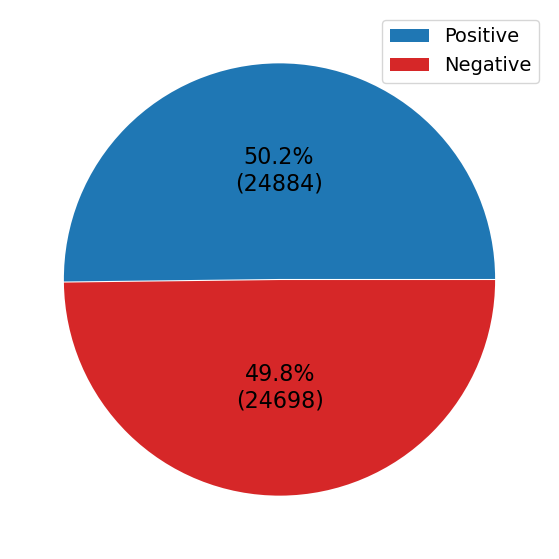

In [3]:
import numpy as np
import seaborn as sns
import matplotlib . pyplot as plt

#Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [ freq_pos , freq_neg ]

labels = ['positive', 'negative']

# Create pie chart
pie , ax = plt.subplots (figsize =[11 ,7])
plt.pie(x=data , autopct = lambda pct:func(pct , data), explode =[0.0025]*2 ,
        pctdistance=0.5 , colors =[ sns.color_palette() [0] , 'tab:red'], textprops ={'fontsize': 16})

# plt.title ('Frequencies of sentiment labels', fontsize =14 , fontweight ='bold')
labels = [r'Positive', r'Negative']
plt.legend (labels , loc ="best", prop ={ 'size': 14})
pie.savefig("PieChart.png")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


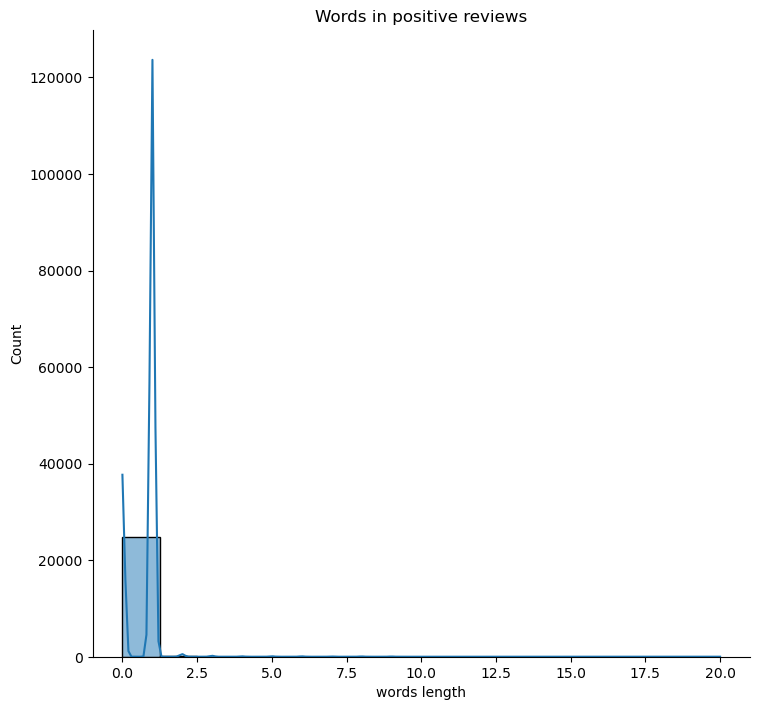

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


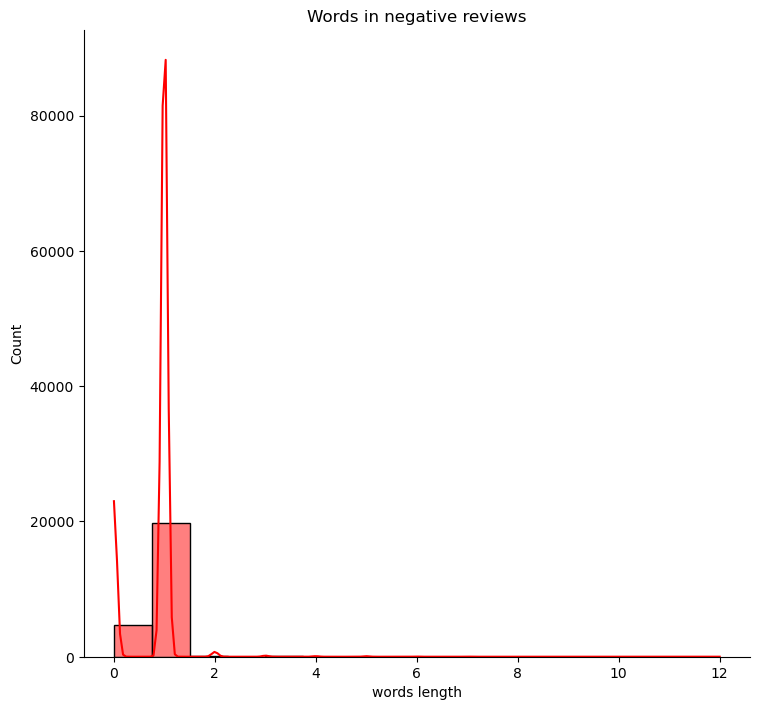

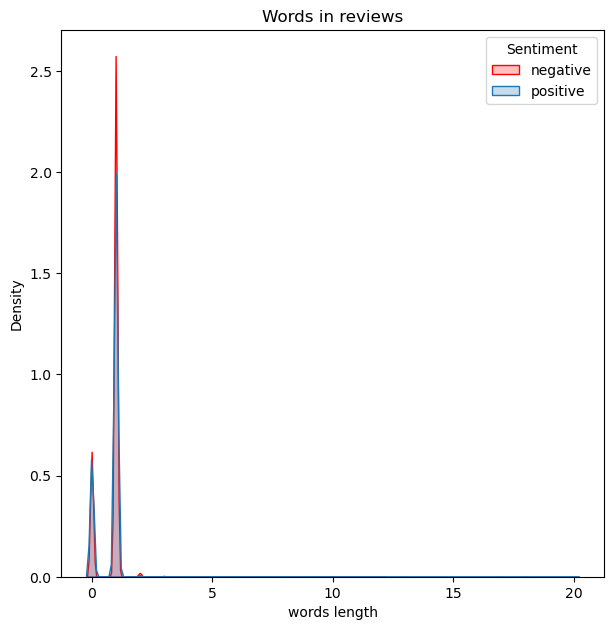

In [4]:
words_len = df['review'].str.split().map( lambda x: len(x))
df_temp = df.copy()
df_temp ['words length'] = words_len

hist_positive = sns.displot(data=df_temp[df_temp['sentiment'] == 'positive'], x="words length", hue="sentiment", 
                            kde=True, height=7, aspect=1.1, legend=False).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(data=df_temp[df_temp['sentiment'] == 'negative'], x="words length", hue="sentiment", 
                            kde=True, height=7, aspect=1.1, legend=False, palette=['red']).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(data=df_temp, x="words length", hue="sentiment", fill=True, 
                                                    palette=[sns.color_palette()[0], 'red']).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show()

**3.Split dataset**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder ()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']

x_train , x_test , y_train , y_test = train_test_split(x_data , y_data , test_size =0.2 , random_state =42 )

**4.Vectorization**

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features =10000)
tfidf_vectorizer.fit( x_train , y_train )

x_train_encoded = tfidf_vectorizer.transform (x_train)
x_test_encoded = tfidf_vectorizer.transform (x_test)

**5.Training and Evaluation**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state =41)
rf_classifier.fit( x_train_encoded , y_train )
y_pred2 = rf_classifier.predict( x_test_encoded )
as1=accuracy_score(y_pred2 , y_test )
print(as1)


0.5019663204598165


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier (criterion ='entropy', random_state =40)
dt_classifier.fit( x_train_encoded , y_train )
y_pred1 = dt_classifier.predict ( x_test_encoded )
as2=accuracy_score(y_pred1 , y_test )
print(as2)

0.5019663204598165
